In [1]:
# install libriaries
# %pip install tensorflow keras opencv-python matplotlib seaborn scikit-learn numpy pandas tqdm

In [1]:
# import libraries
import os
import time
import random
import cv2 as cv
import numpy as np
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

/home/wills/.local/lib/python3.12/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/home/wills/.local/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
2025-08-08 03:24:50.280941: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-08 03:24:53.111507: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-08 03:24:55.574084: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cu

In [2]:
# initializes list for images and label
data_train = "Face Expression Recognition Dataset/train/"
data_test = "Face Expression Recognition Dataset/test/"

# List for arrays
X_train = []
y_train = []
folders = ["surprise", "disgust", "happy", "sad", "fear", "neutral", "angry"]


In [3]:
# Load and append dataset for preprocessing
# Train folder
for folder in folders:
    train_path = data_train + folder
    print("\nCurrent folder:", train_path)
    for current_img in tqdm(os.listdir(train_path)):
        
        try:
            # Read and convert image to Grayscale
            img = cv.imread(train_path + "/" + current_img, cv.IMREAD_GRAYSCALE)
            
            # Display image
            # cv.imshow(f"Original Image {current_img}", img)
            # cv.waitKey(1000)
            
            # resize images
            img = cv.resize(img, (50, 50))
            
            # Show resized imaage
            # cv.imshow(f"Resized Image {current_img}", img)
            # cv.waitKey(1000)
            # cv.destroyAllWindows()
            
            X_train.append(img)
            y_train.append(folder)
            
        except:
            print(f"Error loading: {img}")
        
    print("Appended all images in '{}' folder successfully.".format(folder))
    
print(f"\nFinished processing all images in the folders successfully.")



Current folder: Face Expression Recognition Dataset/train/surprise


100%|██████████| 3991/3991 [00:25<00:00, 157.71it/s]


Appended all images in 'surprise' folder successfully.

Current folder: Face Expression Recognition Dataset/train/disgust


100%|██████████| 537/537 [00:00<00:00, 809.48it/s]


Appended all images in 'disgust' folder successfully.

Current folder: Face Expression Recognition Dataset/train/happy


100%|██████████| 8979/8979 [01:16<00:00, 117.88it/s]


Appended all images in 'happy' folder successfully.

Current folder: Face Expression Recognition Dataset/train/sad


100%|██████████| 6067/6067 [00:47<00:00, 127.30it/s]


Appended all images in 'sad' folder successfully.

Current folder: Face Expression Recognition Dataset/train/fear


100%|██████████| 5111/5111 [00:56<00:00, 89.93it/s] 


Appended all images in 'fear' folder successfully.

Current folder: Face Expression Recognition Dataset/train/neutral


100%|██████████| 6188/6188 [01:27<00:00, 70.88it/s] 


Appended all images in 'neutral' folder successfully.

Current folder: Face Expression Recognition Dataset/train/angry


100%|██████████| 4943/4943 [00:41<00:00, 120.15it/s]

Appended all images in 'angry' folder successfully.

Finished processing all images in the folders successfully.


In [6]:
# Convert to numpy array
X_train = np.array(X_train)
y_train = np.array(y_train)

In [7]:
# Confirm length and splt into test and train
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=32)
print("\nShape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)


Shape of X_train: (22921, 50, 50)
Shape of y_train: (22921,)
Shape of X_test: (5731, 50, 50)
Shape of y_test: (5731,)


In [8]:
# Reshape and normalize
X_train = X_train.reshape(-1, 50, 50, 1).astype('float32') / 255.0
X_test = X_test.reshape(-1, 50, 50, 1).astype('float32') / 255.0

In [9]:
# Encode labels
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

class_names = encoder.classes_
print("\nClasses:", class_names)

# Perform one hot encoding
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)


Classes: ['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']


In [9]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

datagen.fit(X_train)

In [10]:
"""Start building model"""
model = Sequential()

# First layer
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(50, 50, 1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Second layer 
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Third layer 
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


# Fully connected layer 
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))


# Output layer
model.add(Dense(y_train.shape[1], activation='softmax'))

# Compile with label smoothing
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

/home/wills/.local/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-08-08 01:24:48.510799: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [11]:
print("Model Summary on version 2:\n")
model.summary()

Model Summary on version 2:



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 22, 22, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 22, 22, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 11, 11, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 11, 11, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 9, 9, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 9, 9, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,472,711 (9.43 MB)

 Trainable params: 2,471,815 (9.43 MB)

 Non-trainable params: 896 (3.50 KB)

In [12]:
# Callbacks
callbacks = [
    ModelCheckpoint("emotions_model2.h5", monitor='val_accuracy', save_best_only=True, mode='max', verbose=1),
    EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1)
]

In [ ]:
# Use augementation with training
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_test, y_test),
    epochs=30,
    callbacks=callbacks,
    steps_per_epoch=len(X_train) // 64,
    verbose=1
)

Epoch 1/25
447/447 ━━━━━━━━━━━━━━━━━━━━ 0s 643ms/step - accuracy: 0.2245 - loss: 2.1488
Epoch 1: val_accuracy improved from -inf to 0.26912, saving model to emotions_model2.h5


447/447 ━━━━━━━━━━━━━━━━━━━━ 305s 681ms/step - accuracy: 0.2245 - loss: 2.1483 - val_accuracy: 0.2691 - val_loss: 1.8527 - learning_rate: 0.0010
Epoch 2/25
447/447 ━━━━━━━━━━━━━━━━━━━━ 0s 754ms/step - accuracy: 0.2742 - loss: 1.8144
Epoch 2: val_accuracy improved from 0.26912 to 0.27848, saving model to emotions_model2.h5


447/447 ━━━━━━━━━━━━━━━━━━━━ 355s 794ms/step - accuracy: 0.2742 - loss: 1.8144 - val_accuracy: 0.2785 - val_loss: 1.7952 - learning_rate: 0.0010
Epoch 3/25
  2/447 ━━━━━━━━━━━━━━━━━━━━ 2:31 341ms/step - accuracy: 0.2969 - loss: 1.7446

/home/wills/.local/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 3: val_accuracy did not improve from 0.27848
447/447 ━━━━━━━━━━━━━━━━━━━━ 21s 46ms/step - accuracy: 0.3124 - loss: 1.6942 - val_accuracy: 0.2761 - val_loss: 1.7917 - learning_rate: 0.0010
Epoch 4/25
447/447 ━━━━━━━━━━━━━━━━━━━━ 0s 633ms/step - accuracy: 0.2994 - loss: 1.7834
Epoch 4: val_accuracy did not improve from 0.27848
447/447 ━━━━━━━━━━━━━━━━━━━━ 324s 725ms/step - accuracy: 0.2994 - loss: 1.7834 - val_accuracy: 0.2712 - val_loss: 1.7661 - learning_rate: 0.0010
Epoch 5/25
447/447 ━━━━━━━━━━━━━━━━━━━━ 0s 613ms/step - accuracy: 0.3251 - loss: 1.7420
Epoch 5: val_accuracy improved from 0.27848 to 0.37409, saving model to emotions_model2.h5


447/447 ━━━━━━━━━━━━━━━━━━━━ 296s 661ms/step - accuracy: 0.3251 - loss: 1.7420 - val_accuracy: 0.3741 - val_loss: 1.6939 - learning_rate: 0.0010
Epoch 6/25
  2/447 ━━━━━━━━━━━━━━━━━━━━ 4:47 645ms/step - accuracy: 0.2500 - loss: 1.7925
Epoch 6: val_accuracy did not improve from 0.37409
447/447 ━━━━━━━━━━━━━━━━━━━━ 23s 49ms/step - accuracy: 0.2500 - loss: 1.7962 - val_accuracy: 0.3717 - val_loss: 1.6941 - learning_rate: 0.0010
Epoch 7/25
447/447 ━━━━━━━━━━━━━━━━━━━━ 0s 583ms/step - accuracy: 0.3360 - loss: 1.7251
Epoch 7: val_accuracy improved from 0.37409 to 0.37954, saving model to emotions_model2.h5


447/447 ━━━━━━━━━━━━━━━━━━━━ 282s 631ms/step - accuracy: 0.3360 - loss: 1.7251 - val_accuracy: 0.3795 - val_loss: 1.6483 - learning_rate: 0.0010
Epoch 8/25
447/447 ━━━━━━━━━━━━━━━━━━━━ 0s 504ms/step - accuracy: 0.3599 - loss: 1.6950
Epoch 8: val_accuracy improved from 0.37954 to 0.41625, saving model to emotions_model2.h5


447/447 ━━━━━━━━━━━━━━━━━━━━ 245s 547ms/step - accuracy: 0.3599 - loss: 1.6950 - val_accuracy: 0.4162 - val_loss: 1.5958 - learning_rate: 0.0010
Epoch 9/25
  2/447 ━━━━━━━━━━━━━━━━━━━━ 3:32 478ms/step - accuracy: 0.3828 - loss: 1.6385
Epoch 9: val_accuracy did not improve from 0.41625
447/447 ━━━━━━━━━━━━━━━━━━━━ 19s 41ms/step - accuracy: 0.3595 - loss: 1.6828 - val_accuracy: 0.4087 - val_loss: 1.6057 - learning_rate: 0.0010
Epoch 10/25
447/447 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step - accuracy: 0.3608 - loss: 1.6850
Epoch 10: val_accuracy did not improve from 0.41625
447/447 ━━━━━━━━━━━━━━━━━━━━ 238s 532ms/step - accuracy: 0.3608 - loss: 1.6850 - val_accuracy: 0.4126 - val_loss: 1.5908 - learning_rate: 0.0010
Epoch 11/25
447/447 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step - accuracy: 0.3779 - loss: 1.6648
Epoch 11: val_accuracy did not improve from 0.41625
447/447 ━━━━━━━━━━━━━━━━━━━━ 235s 525ms/step - accuracy: 0.3780 - loss: 1.6648 - val_accuracy: 0.4104 - val_loss: 1.5750 - learning_rate: 0.0010

447/447 ━━━━━━━━━━━━━━━━━━━━ 20s 42ms/step - accuracy: 0.3124 - loss: 1.7847 - val_accuracy: 0.4305 - val_loss: 1.5574 - learning_rate: 0.0010
Epoch 13/25
447/447 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step - accuracy: 0.3753 - loss: 1.6685
Epoch 13: val_accuracy did not improve from 0.43049
447/447 ━━━━━━━━━━━━━━━━━━━━ 229s 512ms/step - accuracy: 0.3753 - loss: 1.6685 - val_accuracy: 0.3076 - val_loss: 1.7410 - learning_rate: 0.0010
Epoch 14/25
447/447 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step - accuracy: 0.3792 - loss: 1.6538
Epoch 14: val_accuracy did not improve from 0.43049
447/447 ━━━━━━━━━━━━━━━━━━━━ 231s 516ms/step - accuracy: 0.3792 - loss: 1.6538 - val_accuracy: 0.3580 - val_loss: 1.6728 - learning_rate: 0.0010
Epoch 15/25
  2/447 ━━━━━━━━━━━━━━━━━━━━ 4:19 582ms/step - accuracy: 0.4062 - loss: 1.5885
Epoch 15: val_accuracy did not improve from 0.43049

Epoch 15: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
447/447 ━━━━━━━━━━━━━━━━━━━━ 19s 41ms/step - accuracy: 0.4374 -

447/447 ━━━━━━━━━━━━━━━━━━━━ 233s 522ms/step - accuracy: 0.4118 - loss: 1.6205 - val_accuracy: 0.4894 - val_loss: 1.4798 - learning_rate: 2.0000e-04
Epoch 17/25
447/447 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step - accuracy: 0.4235 - loss: 1.5974
Epoch 17: val_accuracy improved from 0.48939 to 0.49037, saving model to emotions_model2.h5


447/447 ━━━━━━━━━━━━━━━━━━━━ 235s 525ms/step - accuracy: 0.4235 - loss: 1.5974 - val_accuracy: 0.4904 - val_loss: 1.4966 - learning_rate: 2.0000e-04
Epoch 18/25
  2/447 ━━━━━━━━━━━━━━━━━━━━ 3:23 456ms/step - accuracy: 0.5312 - loss: 1.4862
Epoch 18: val_accuracy improved from 0.49037 to 0.49260, saving model to emotions_model2.h5


447/447 ━━━━━━━━━━━━━━━━━━━━ 19s 42ms/step - accuracy: 0.5312 - loss: 1.4992 - val_accuracy: 0.4926 - val_loss: 1.4919 - learning_rate: 2.0000e-04
Epoch 19/25
447/447 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step - accuracy: 0.4188 - loss: 1.5987
Epoch 19: val_accuracy improved from 0.49260 to 0.49470, saving model to emotions_model2.h5


447/447 ━━━━━━━━━━━━━━━━━━━━ 234s 523ms/step - accuracy: 0.4188 - loss: 1.5987 - val_accuracy: 0.4947 - val_loss: 1.4603 - learning_rate: 2.0000e-04
Epoch 20/25
447/447 ━━━━━━━━━━━━━━━━━━━━ 0s 503ms/step - accuracy: 0.4315 - loss: 1.5705
Epoch 20: val_accuracy improved from 0.49470 to 0.49651, saving model to emotions_model2.h5


447/447 ━━━━━━━━━━━━━━━━━━━━ 245s 547ms/step - accuracy: 0.4315 - loss: 1.5705 - val_accuracy: 0.4965 - val_loss: 1.4560 - learning_rate: 2.0000e-04
Epoch 21/25
  2/447 ━━━━━━━━━━━━━━━━━━━━ 4:24 593ms/step - accuracy: 0.4062 - loss: 1.6290
Epoch 21: val_accuracy improved from 0.49651 to 0.49846, saving model to emotions_model2.h5


447/447 ━━━━━━━━━━━━━━━━━━━━ 23s 50ms/step - accuracy: 0.4374 - loss: 1.5579 - val_accuracy: 0.4985 - val_loss: 1.4545 - learning_rate: 2.0000e-04
Epoch 22/25
447/447 ━━━━━━━━━━━━━━━━━━━━ 0s 552ms/step - accuracy: 0.4360 - loss: 1.5644
Epoch 22: val_accuracy did not improve from 0.49846
447/447 ━━━━━━━━━━━━━━━━━━━━ 266s 596ms/step - accuracy: 0.4360 - loss: 1.5644 - val_accuracy: 0.4845 - val_loss: 1.4900 - learning_rate: 2.0000e-04
Epoch 23/25
447/447 ━━━━━━━━━━━━━━━━━━━━ 0s 558ms/step - accuracy: 0.4373 - loss: 1.5633
Epoch 23: val_accuracy improved from 0.49846 to 0.50181, saving model to emotions_model2.h5


447/447 ━━━━━━━━━━━━━━━━━━━━ 270s 604ms/step - accuracy: 0.4373 - loss: 1.5633 - val_accuracy: 0.5018 - val_loss: 1.4570 - learning_rate: 2.0000e-04
Epoch 24/25
  2/447 ━━━━━━━━━━━━━━━━━━━━ 4:06 554ms/step - accuracy: 0.4375 - loss: 1.5304
Epoch 24: val_accuracy did not improve from 0.50181

Epoch 24: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
447/447 ━━━━━━━━━━━━━━━━━━━━ 21s 46ms/step - accuracy: 0.4375 - loss: 1.5436 - val_accuracy: 0.5018 - val_loss: 1.4642 - learning_rate: 2.0000e-04
Epoch 25/25
447/447 ━━━━━━━━━━━━━━━━━━━━ 0s 586ms/step - accuracy: 0.4518 - loss: 1.5505
Epoch 25: val_accuracy improved from 0.50181 to 0.51424, saving model to emotions_model2.h5


447/447 ━━━━━━━━━━━━━━━━━━━━ 284s 636ms/step - accuracy: 0.4518 - loss: 1.5505 - val_accuracy: 0.5142 - val_loss: 1.4306 - learning_rate: 4.0000e-05


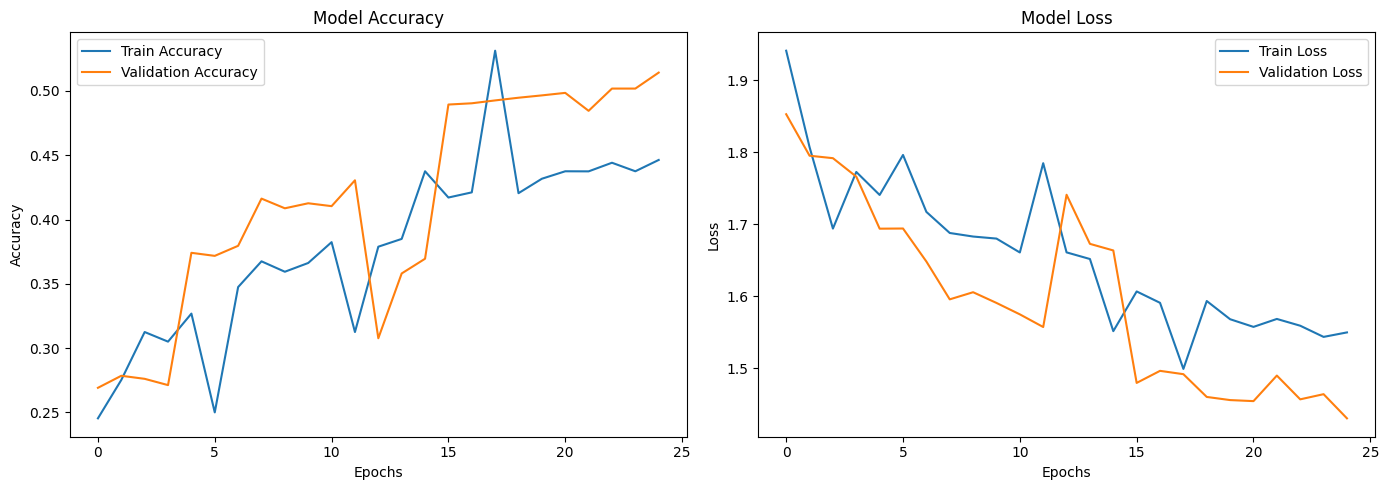

In [18]:
# Metrics graphs
plt.figure(figsize=(14,5))

# plot accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# plot loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


180/180 ━━━━━━━━━━━━━━━━━━━━ 17s 86ms/step - accuracy: 0.5274 - loss: 1.4033

Test Accuracy: 51.98%
180/180 ━━━━━━━━━━━━━━━━━━━━ 16s 85ms/step
Classification Report:

              precision    recall  f1-score   support

       angry       0.39      0.36      0.38       758
     disgust       0.00      0.00      0.00        99
        fear       0.30      0.07      0.12       816
       happy       0.69      0.86      0.77      1436
     neutral       0.43      0.59      0.50       992
         sad       0.39      0.36      0.37      1006
    surprise       0.60      0.74      0.66       624

    accuracy                           0.52      5731
   macro avg       0.40      0.43      0.40      5731
weighted avg       0.48      0.52      0.48      5731



/home/wills/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/wills/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/wills/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


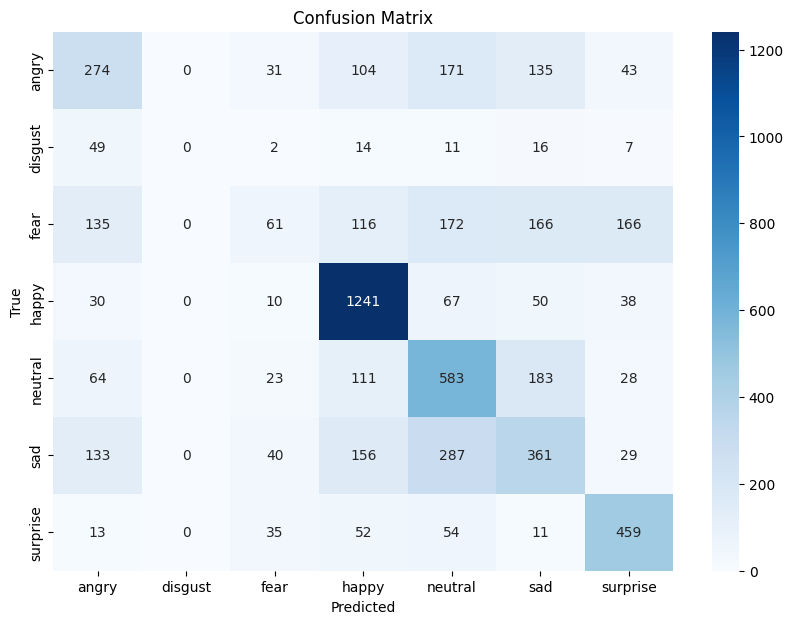

In [10]:
#load model and predict

model = load_model("emotions_model2.h5")

#Evaluation on test data
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"\nTest Accuracy: {test_accuracy * 100:.2f}%")

#Predict labels
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)


# classification Report
print("Classification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=encoder.classes_))

# plot confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10,7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

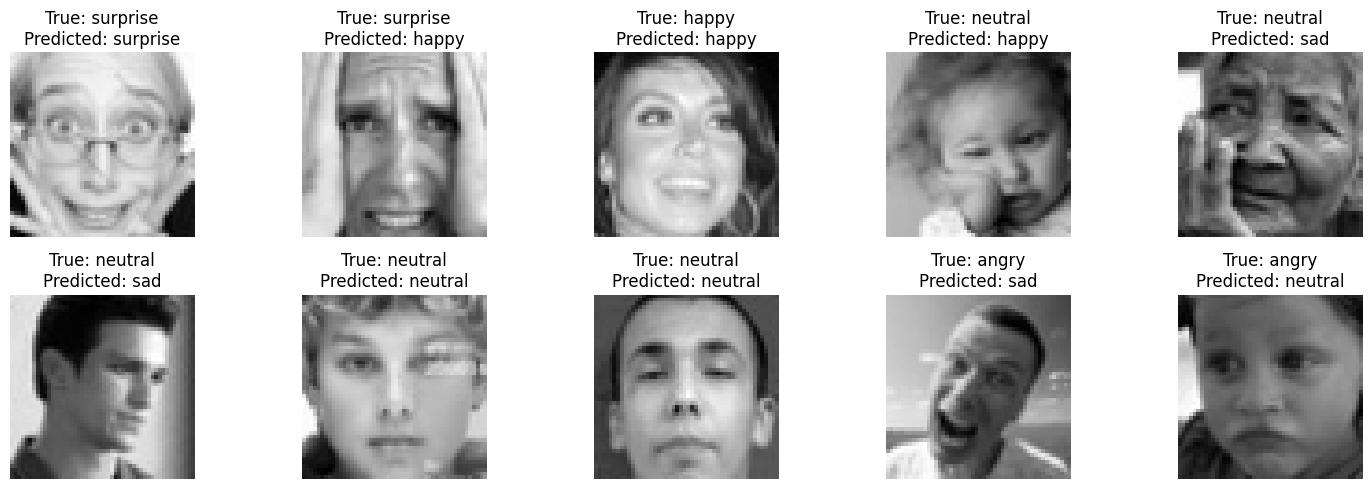

In [11]:
# Display 10 random test images with predicted and actual emotions
plt.figure(figsize=(15, 5))
for i in range(10):
    idx = random.randint(0, len(X_test) - 1)
    img = X_test[idx].reshape(50, 50)
    true_label = encoder.classes_[y_true[idx]]
    pred_label = encoder.classes_[y_pred_classes[idx]]
    
    plt.subplot(2, 5, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"True: {true_label}\nPredicted: {pred_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [12]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    data_test,
    target_size=(50, 50),
    color_mode="grayscale",
    batch_size=64,
    class_mode='categorical'
)

Found 70 images belonging to 7 classes.


In [ ]:
def predict_emotion(img_path):
    img = cv.imread(img_path, cv.IMREAD_GRAYSCALE)

    if img is None:
        print("Error: File not found. Check the path or file format.")
        return None

    img = cv.resize(img, (50, 50))
    img = img.reshape(1, 50, 50, 1) / 255.0

    prediction = model.predict(img)
    
    # Directly hardcoded class labels
    class_labels = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
    predicted_label = class_labels[np.argmax(prediction)]

    return predicted_label


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


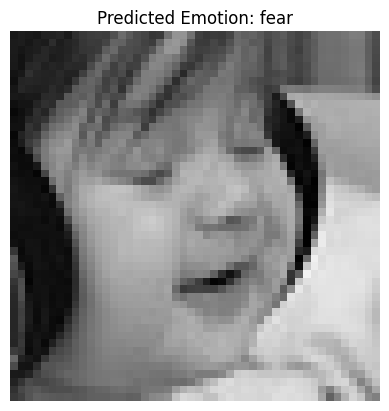

In [35]:
def show_image_with_prediction(img_path):
    emotion = predict_emotion(img_path)
    if emotion:
        img = cv.imread(img_path)
        plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
        plt.title(f"Predicted Emotion: {emotion}")
        plt.axis('off')
        plt.show()

# Use it:
show_image_with_prediction("Face Expression Recognition Dataset/test/happy/happy_test_09.jpg")
